In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
fpath = '/content/drive/MyDrive/BMI_Deep_Learning_Course/final_project/'
dataset = pd.read_csv(fpath+'data/shuffled_data.csv', index_col=0) # 952 total samples (0-951)
dataset.drop(columns=['index'], inplace=True)
dataset.head()

,Sample,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Gemellaceae;g__Gemella,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Neisseriaceae;g__Neisseria,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Bilophila,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Stoquefichus,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,...,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Ruminococcus,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales_A;f__Turicibacteraceae;g__Turicibacter,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A,Condition
0,10720,0.000010,0.000011,0.000009,0.002025,0.000224,0.000649,8.900108e-07,0.019677,0.000004,...,0.000103,0.004792,0.003215,0.008747,0.001978,0.000021,0.000003,0.000016,0.000018,1
1,A019,0.000000,0.000012,0.000000,0.000000,0.106643,0.000000,0.000000e+00,0.000024,0.000023,...,0.000000,0.000000,0.010040,0.096365,0.000108,0.000000,0.000240,0.000005,0.000000,0
2,CRC.175,0.000000,0.000000,0.000000,0.000000,0.030303,0.015152,0.000000e+00,0.000000,0.000000,...,0.113636,0.000000,0.053030,0.030303,0.000000,0.000000,0.000000,0.000000,0.030303,1
3,PRISM.7776,0.000354,0.000008,0.000007,0.001121,0.003483,0.107623,6.878160e-06,0.000114,0.001418,...,0.000457,0.000011,0.009127,0.221212,0.000227,0.000003,0.000517,0.000007,0.000051,2
4,Validation.UMCG6047689,0.000008,0.000002,0.000003,0.001584,0.002361,0.030603,5.449742e-06,0.013034,0.000309,...,0.000342,0.000013,0.000073,0.127677,0.000694,0.000026,0.000063,0.000047,0.000027,2


## Split Data into Train & Test Sets

In [3]:
start_train_idx = 0
end_train_idx = round(len(dataset)*0.80)

start_valid_idx = end_train_idx
end_valid_idx = len(dataset)

In [4]:
# Create X and y
X = dataset.drop(["Sample", "Condition"], axis=1)
y = dataset["Condition"]

In [5]:
X_train = X[start_train_idx:end_train_idx]
X_train.reset_index(drop=True,inplace=True)

X_valid = X[start_valid_idx:end_valid_idx]
X_valid.reset_index(drop=True,inplace=True)

y_train = y[start_train_idx:end_train_idx]
y_train.reset_index(drop=True,inplace=True)

y_valid = y[start_valid_idx:end_valid_idx]
y_valid.reset_index(drop=True,inplace=True)

In [6]:
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{y.value_counts() / len(dataset)}\n\n'+
      f'PROPORTION OF TARGET IN THE TRAINING SET\n{y_train.value_counts() / len(y_train)}\n\n'+
      f'PROPORTION OF TARGET IN THE VALIDATION SET\n{y_valid.value_counts() / len(y_valid)}')

PROPORTION OF TARGET IN THE ORIGINAL DATA
Condition
0    0.506303
1    0.283613
2    0.210084
Name: count, dtype: float64

PROPORTION OF TARGET IN THE TRAINING SET
Condition
0    0.510499
1    0.276903
2    0.212598
Name: count, dtype: float64

PROPORTION OF TARGET IN THE VALIDATION SET
Condition
0    0.489474
1    0.310526
2    0.200000
Name: count, dtype: float64


## Save Tensors to Image Files (DO NOT RERUN)

In [ ]:
from torchvision.utils import save_image
round_idx = round(len(dataset)*0.80)

for i in range(0,len(X_train)):
  #print("train i is "+str(i))
  features = list(X_train.iloc[i])
  # create a tensor with 9 rows and 5 columns (5*9=45)
  tensor = torch.tensor(features)
  tensor = tensor.view(9, 5)

  label = y_train[i]
  name = 'sample'+str(i)+"_"+str(label)

  save_image(tensor,  fpath+'data/images/train/'+name+'.png')

for i in range(0,len(X_valid)):
  #print("test i is "+str(i))
  features = list(X_valid.iloc[i])
  # create a tensor with 9 rows and 5 columns (5*9=45)
  tensor = torch.tensor(features)
  tensor = tensor.view(9, 5)

  label = y_valid[i]
  name = 'sample'+str(i+round_idx)+"_"+str(label)

  save_image(tensor,  fpath+'data/images/valid/'+name+'.png')

## Model 1: Image Learner

In [21]:
fnames = get_image_files(fpath+"data/images")
len(fnames)

952

In [22]:
def label_func(f):
  label = str(f)[-5]
  return int(label)

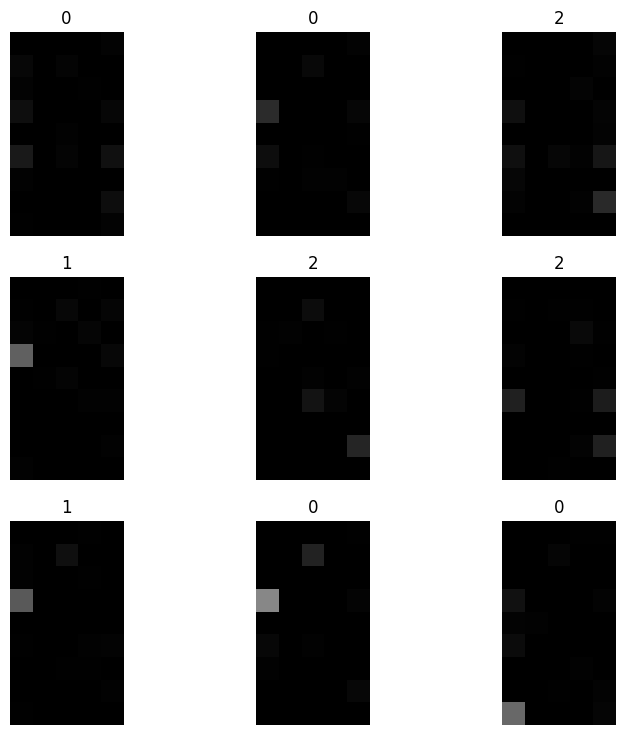

In [23]:
dls = ImageDataLoaders.from_name_func(path = fpath+"data/images", fnames=fnames, train="train", valid="valid", bs=64, label_func=label_func)
dls.show_batch()

resnet34: a pretrained model from torchvision

Try out: metrics=error_rate, metrics=accuracy...

In [47]:
learn = vision_learner(dls, resnet50, metrics=accuracy) # gives 0.71 and 0.76
learn.fine_tune(1)
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.872947,3.020744,0.252632,00:11


epoch,train_loss,valid_loss,accuracy,time
0,1.919602,3.082750,0.247368,00:22


In [41]:
learn.fit(5, 0.00363)

epoch,train_loss,valid_loss,accuracy,time
0,1.964552,1.155447,0.489474,00:37
1,1.792481,3.887648,0.484211,00:08
2,1.622056,8.290689,0.547368,00:07
3,1.503354,4.166393,0.357895,00:08
4,1.415052,2.229646,0.415789,00:08


In [42]:
interp = ClassificationInterpretation.from_learner(learn)

In [43]:
interp.confusion_matrix()

array([[39, 44, 13],
       [25, 23,  2],
       [19,  8, 17]])

In [ ]:
learn.show_results()

In [ ]:
learn.save(fpath+'data/VISION_MODEL')

Path('/content/drive/MyDrive/BMI_Deep_Learning_Course/final_project/data/VISION_MODEL.pth')

In [ ]:
learn = load_learner(fpath+'data/VISION_MODEL')

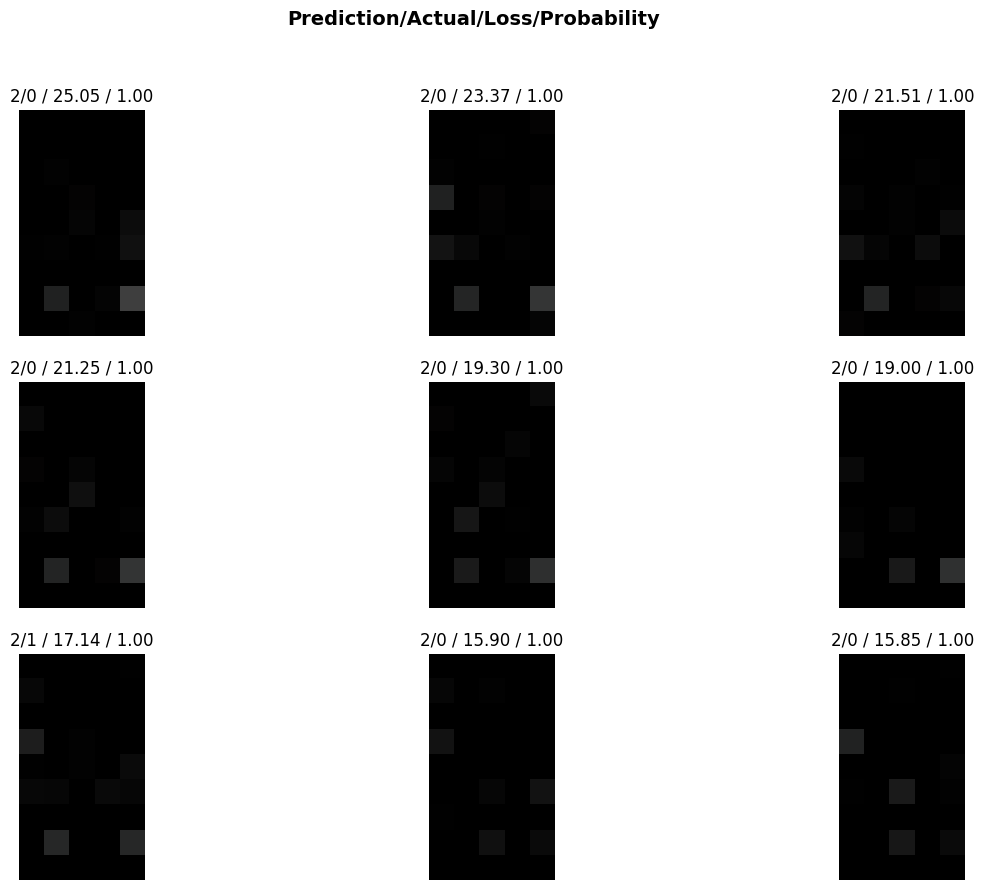

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

## Model 2: Tabular Learner

In [7]:
train_indices = list(range(start_train_idx, end_train_idx))
valid_indices = list(range(start_valid_idx, end_valid_idx))

splits = (L(train_indices), L(valid_indices))

In [8]:
from fastai.tabular.all import *

bacteria_names = list(dataset.columns)[1:-1]
target_var = dataset.columns[-1]

to = TabularPandas(dataset, cont_names = bacteria_names, y_names=target_var, splits=splits, y_block = CategoryBlock)
to.xs.iloc[:2]

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Gemellaceae;g__Gemella,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Neisseriaceae;g__Neisseria,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Bilophila,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Stoquefichus,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella,...,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Eggerthella,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Ruminococcus,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales_A;f__Turicibacteraceae;g__Turicibacter,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A
0,0.00001,0.000011,0.000009,0.002025,0.000224,0.000649,8.900108e-07,0.019677,0.000004,0.001267,...,0.000123,0.000103,0.004792,0.003215,0.008747,0.001978,0.000021,0.000003,0.000016,0.000018
1,0.00000,0.000012,0.000000,0.000000,0.106643,0.000000,0.000000e+00,0.000024,0.000023,0.007800,...,0.000296,0.000000,0.000000,0.010040,0.096365,0.000108,0.000000,0.000240,0.000005,0.000000


In [9]:
dls = to.dataloaders(bs=64)
dls.show_batch()

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Gemellaceae;g__Gemella,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Neisseriaceae;g__Neisseria,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Bilophila,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Stoquefichus,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Clostridium_AQ,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Christensenellales;f__Christensenellaceae;g__Christensenella,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Eubacteriales;f__Eubacteriaceae;g__Eubacterium,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Coprobacteraceae;g__Coprobacter,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Coprococcus,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospira,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Megamonas,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Acidaminococcus,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Ruminococcus_B,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Catenibacterium,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Veillonellales;f__Dialisteraceae;g__Dialister,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__Clostridioides,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Anaerostipes,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Flavonifractor,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Bifidobacteriaceae;g__Bifidobacterium,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Dorea_A,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Adlercreutzia,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinifilaceae;g__Butyricimonas,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinifilaceae;g__Odoribacter,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Anaerotruncus,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Eggerthella,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Ruminococcus,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bac

In [24]:
# replace above code with something simpler
simple_net = nn.Sequential(
    nn.Linear(9*5,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

# update mnist_loss to first apply sigmoid function to inputs...
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()


# gives the following function to calculate validation accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [25]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [26]:
learn.fit(10, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1728x5 and 45x30)

In [12]:
learn = tabular_learner(dls, metrics=accuracy_multi)
#learn.lr_find()
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy_multi,time


AssertionError: Exception occured in `Recorder` when calling event `after_batch`:
	==:
192
64

In [56]:
learn.fit(5, 0.002)

epoch,train_loss,valid_loss,mse,time


AssertionError: Exception occured in `Recorder` when calling event `after_batch`:
	==:
192
64

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

In [34]:
interp.confusion_matrix()

array([[58, 25, 10],
       [24, 34,  1],
       [11,  7, 20]])

In [ ]:
type(to)

fastai.tabular.core.TabularPandas